## BB Desafio i9

### Desafio #4 - Amazon AWS

Informações gerais disponíveis no <a href="https://github.com/scoton/aws-nlp-workshop">github do desafio</a>.

### Características deste trabalho
<p>O objetivo é comparar o serviço de análise de sentimentos da Amazon, chamado de Comprehend, com o classificador Naive Bayes do Sickit Learn.</p>
<p>Para tal foram coletados 510 comentários de usuários do app do Banco do Brasil na Play Store entre os dias 21/07/2019 e 27/10/2019. Esses comentários foram divididos em 450 comentários para treinamento e 60 comentários para validação.</p>
<p>Os comentários foram classificados como 1 e 0, onde 1 indica que trata-se de uma reclamação e 0 de que não se trata de uma reclamação.</p>

### Benefícios para o Banco do Brasil
Este trabalho se mostra interessante, pois, a partir dele, pode-se criar uma API que dispara um alerta indicando a necessidade de contatar o usuário pois o mesmo postou uma crítica, seja contra o app seja contra o Banco do Brasil.

___

### Parte 1: Perfil dos arquivos de treinamento e validação

In [1]:
import pandas as pd
df_treino = pd.read_csv('dados/AppBB3.csv', names = ['classificacao', 'Comentario'])
df_valid  = pd.read_csv('dados/BBApp-Teste.csv', sep=';')

In [2]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
classificacao    450 non-null int64
Comentario       450 non-null object
dtypes: int64(1), object(1)
memory usage: 7.1+ KB


In [3]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
Reclamação1    60 non-null object
Reclamação2    60 non-null object
Comentario     60 non-null object
dtypes: object(3)
memory usage: 1.5+ KB


In [4]:
df_treino.head()

,classificacao,Comentario
0,0,Muito bom ajuda muito
1,0,excelente
2,0,Bom
3,0,aplicativo muito top
4,0,Fácil e prático


In [5]:
df_valid.head()

,Reclamação1,Reclamação2,Comentario
0,sim,sim,Muito bom o App. Sugiro uma melhoria na aba tr...
1,NÃO,NÃO,excelente
2,NÃO,NÃO,Muito eficiente e rápido
3,NÃO,NÃO,muito útil no dia a dia!!!!!
4,NÃO,NÃO,"estou gostando muito, pois é bem prático e fác..."


O dataframe de validação necessita de ETL

In [6]:
# transformar os campos Reclamação1 e Reclamação2 para minúsculo
df_valid['Reclamação1'] = df_valid['Reclamação1'].str.lower()
df_valid['Reclamação2'] = df_valid['Reclamação2'].str.lower()

In [7]:
# Esta função irá criar a classe a ser predita
def reclamacao(df):
  if (df['Reclamação1'] == 'sim' or df['Reclamação2'] == 'sim'):
    return 1
  else:
    return 0

# gerar o alvo
df_valid['Target'] = df_valid.apply(reclamacao, axis = 1)

Perfil dos dados de treinamento

In [8]:
df_treino.classificacao.value_counts()

0    401
1     49
Name: classificacao, dtype: int64

Perfil dos dados de validação

In [9]:
df_valid.Target.value_counts()

0    54
1     6
Name: Target, dtype: int64

___

### Parte 2: Treinamento e validação com Amazon Comprehend

In [10]:
from IPython.display import Image

Foi criado um classificador customizado com os dados de treinamento, que recebeu o nome de AppBBSentimento:

In [11]:
Image(url = 'imagens/custom_class.png')

O dataframe de validação foi submedito a análise da plataforma através da criação de um job:

In [12]:
Image(url = 'imagens/createJob.png')

O resultado foi disponibilizado no Amazon S3 como arquivo jsonl

___

### Parte 3 - Treinamento e validação com Multinomial Naive Bayes

Preparar o dataframe de validação par ter somente os campos necessários

In [13]:
df_valid.drop(['Reclamação1', 'Reclamação2'], axis = 1, inplace = True)

In [14]:
# organizar os dataframes para ficarem com as colunas na mesma ordem
cols_v = ['Comentario', 'Target']
cols_t = ['Comentario', 'classificacao']
df_treino = df_treino[cols_t]
df_valid  = df_valid[cols_v]

In [15]:
df_valid.head()

,Comentario,Target
0,Muito bom o App. Sugiro uma melhoria na aba tr...,1
1,excelente,0
2,Muito eficiente e rápido,0
3,muito útil no dia a dia!!!!!,0
4,"estou gostando muito, pois é bem prático e fác...",0


In [16]:
df_treino.head()

,Comentario,classificacao
0,Muito bom ajuda muito,0
1,excelente,0
2,Bom,0
3,aplicativo muito top,0
4,Fácil e prático,0


In [17]:
# gerar os dados de treino e alvo (X e y)
y = df_treino.classificacao
X = df_treino.Comentario

In [18]:
# segregar os dados em 80% para treino e 20% para teste mantendo a proporção quanto a classificação/target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [19]:
# criar tf-idf sem stop-words
# Importar TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciar o objeto
tfidf_vectorizer = TfidfVectorizer()

# Transformar os dados de treino e de teste
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test  = tfidf_vectorizer.transform(X_test)

In [20]:
# Criar classificador Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB # importar o classificador
from sklearn import metrics # importar avaliardor

# Tunning do modelo
import numpy as np
alphas = np.arange(0, 1, 0.1) # Criar lista de alphas

# criar função para treinar e testar
def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha = alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))

Alpha:  0.0
Score:  0.8888888888888888
Alpha:  0.1
Score:  0.9444444444444444
Alpha:  0.2
Score:  0.9555555555555556
Alpha:  0.30000000000000004
Score:  0.9444444444444444
Alpha:  0.4
Score:  0.9222222222222223
Alpha:  0.5
Score:  0.8888888888888888
Alpha:  0.6000000000000001
Score:  0.8888888888888888
Alpha:  0.7000000000000001
Score:  0.8888888888888888
Alpha:  0.8
Score:  0.8888888888888888
Alpha:  0.9
Score:  0.8888888888888888


/home/angelo/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [21]:
# repetir o processo, agora utilizando somente o dataframe de treinamento
# para confrontá-lo com o de validação

# gerar o tf-idf de treinamento e de validação
tfidf_train = tfidf_vectorizer.fit_transform(X)
tfidf_valid = tfidf_vectorizer.transform(df_valid.Comentario)

# treinar o modelo com o melhor alpha
nb_classifier = MultinomialNB(alpha = 0.2)
nb_classifier.fit(tfidf_train, y)

# fazer a predição
pred_nb = nb_classifier.predict(tfidf_valid)

___

### Parte 4: Comparação dos modelo Naive Bayes com AWS Comprehend

In [22]:
# criar função que gera matriz de confusão

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# função para criar a matriz de confusão
# fonte: documentação do sklearn
nm_clss_alvo = [0, 1]

def plot_confusion_matrix(y_true,
                          y_pred, 
                          classes,
                          nome_modelo,
                          normalize = False,
                          title     = None,
                          cmap      = plt.cm.OrRd):

    title = 'Matriz de Confusão ' + nome_modelo

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax = ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Categoria real',
           xlabel='Categoria predita')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision = 2)

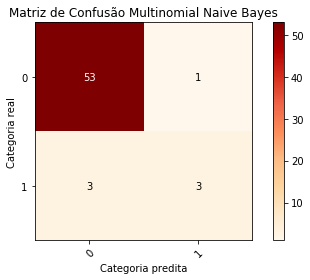

In [23]:
# Matriz de confusão para Multinomial NB
plot_confusion_matrix(df_valid.Target, pred_nb, nm_clss_alvo, 'Multinomial Naive Bayes')

In [24]:
# score do Multinomial NB
score = metrics.accuracy_score(df_valid.Target, pred_nb)
score

0.9333333333333333

In [25]:
# importar os dados preditos pelo AWS Comprehend
df_aws = pd.read_csv('dados/predicaoAWS.csv', sep = ';')

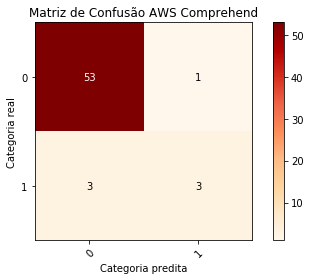

In [26]:
# Matriz de confusão para o AWS Comprehend
plot_confusion_matrix(df_valid.Target, df_aws.Predição, nm_clss_alvo, 'AWS Comprehend')

In [27]:
# score AWS Comprehend
score = metrics.accuracy_score(df_valid.Target, df_aws.Predição)
score

0.9333333333333333

___